                Age   Sleep Hours  Physical Activity (hrs/week)  \
count  11000.000000  11000.000000                  11000.000000   
mean      40.241727      6.650691                      2.942136   
std       13.236140      1.227509                      1.827825   
min       18.000000      2.300000                      0.000000   
25%       29.000000      5.900000                      1.500000   
50%       40.000000      6.700000                      2.800000   
75%       51.000000      7.500000                      4.200000   
max       64.000000     11.300000                     10.100000   

       Caffeine Intake (mg/day)  Alcohol Consumption (drinks/week)  \
count              11000.000000                       11000.000000   
mean                 286.090000                           9.701636   
std                  144.813157                           5.689713   
min                    0.000000                           0.000000   
25%                  172.000000               

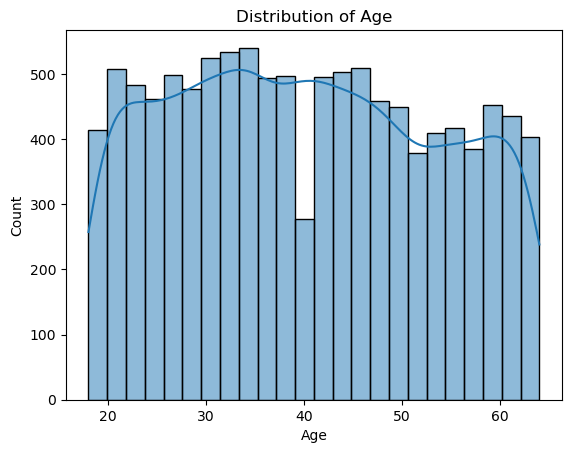

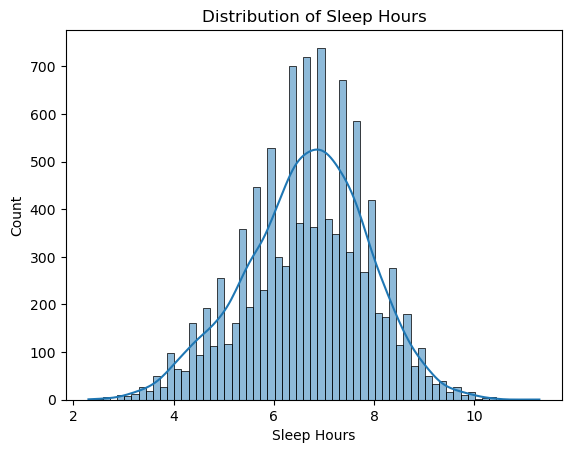

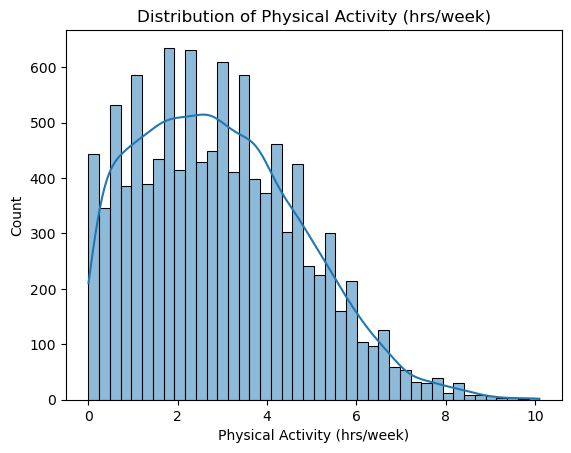

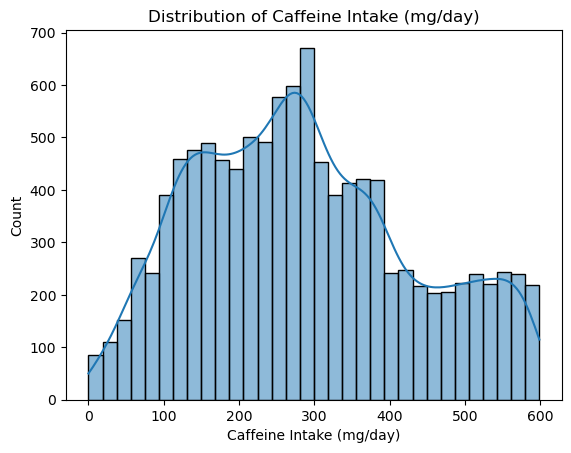

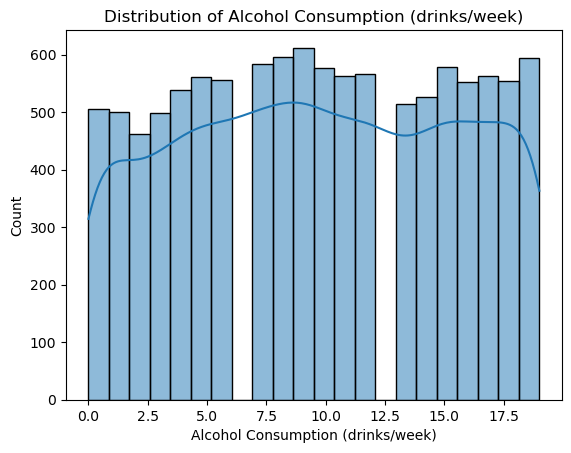

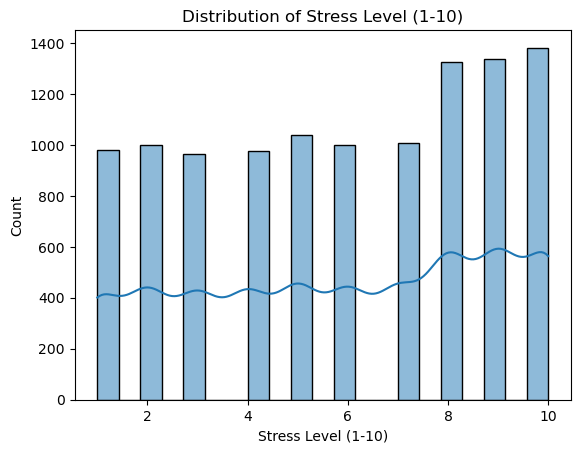

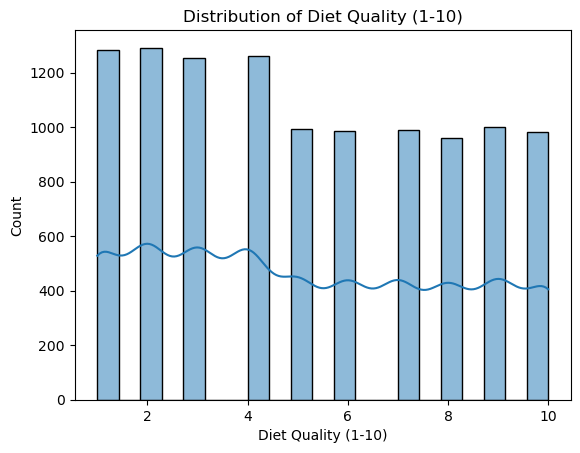

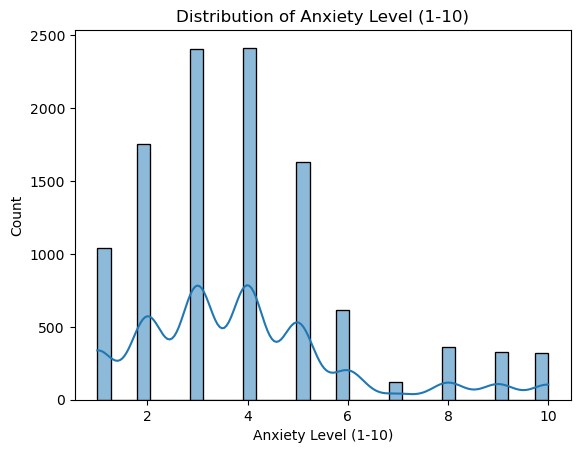

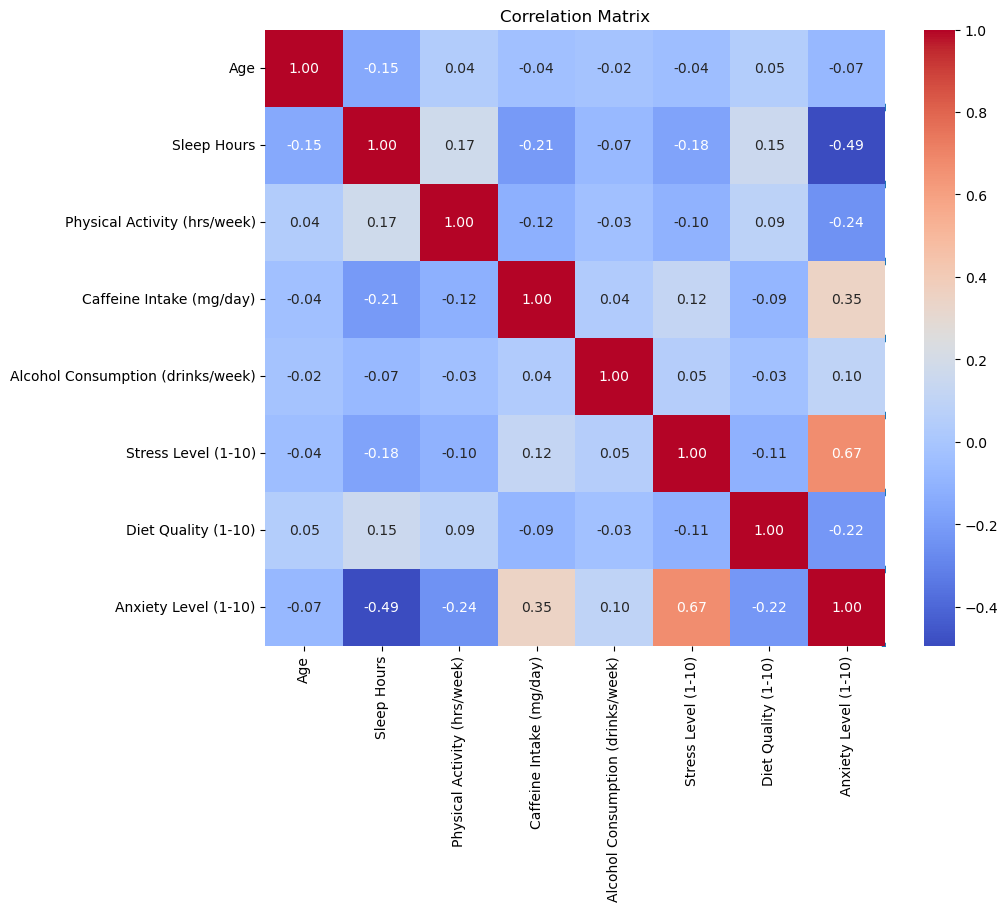

In [1]:
# eda.py
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# ensure the output folder exists
os.makedirs('plots', exist_ok=True)
# 1. Data Loading
df = pd.read_csv('anxiety.csv')

# 2. Summary Statistics
print(df.describe())
print(df.info())

# 3. Univariate Analysis
numeric_cols = ['Age', 'Sleep Hours', 'Physical Activity (hrs/week)', 'Caffeine Intake (mg/day)',
                'Alcohol Consumption (drinks/week)', 'Stress Level (1-10)', 'Diet Quality (1-10)', 'Anxiety Level (1-10)']
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.savefig('plots/{col}_dist.png')

# 4. Bivariate Analysis
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Stress Level (1-10)', y='Anxiety Level (1-10)', data=df)
plt.title('Stress vs Anxiety')
plt.savefig('stress_vs_anxiety.png')

# 5. Correlation Matrix & Heatmap
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('correlation_heatmap.png')

Logistic Regression CV macro‑F1 = 0.295 ± 0.009
Random Forest CV macro‑F1 = 0.273 ± 0.009
XGBoost CV macro‑F1 = 0.278 ± 0.015

Best model on CV: Logistic Regression



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

Test Accuracy    = 0.365
Test macro‑F1     = 0.273

Classification Report (original labels):

              precision    recall  f1-score   support

         1.0      0.468     0.418     0.442       208
         2.0      0.383     0.336     0.358       351
         3.0      0.353     0.405     0.377       481
         4.0      0.373     0.470     0.416       483
         5.0      0.364     0.353     0.358       326
         6.0      0.217     0.041     0.068       123
         7.0      0.000     0.000     0.000        25
         8.0      0.333     0.548     0.415        73
         9.0      0.178     0.121     0.144        66
        10.0      0.200     0.125     0.154        64

    accuracy                          0.365      2200
   macro avg      0.287     0.282     0.273      2200
weighted avg      0.353     0.365     0.352      2200



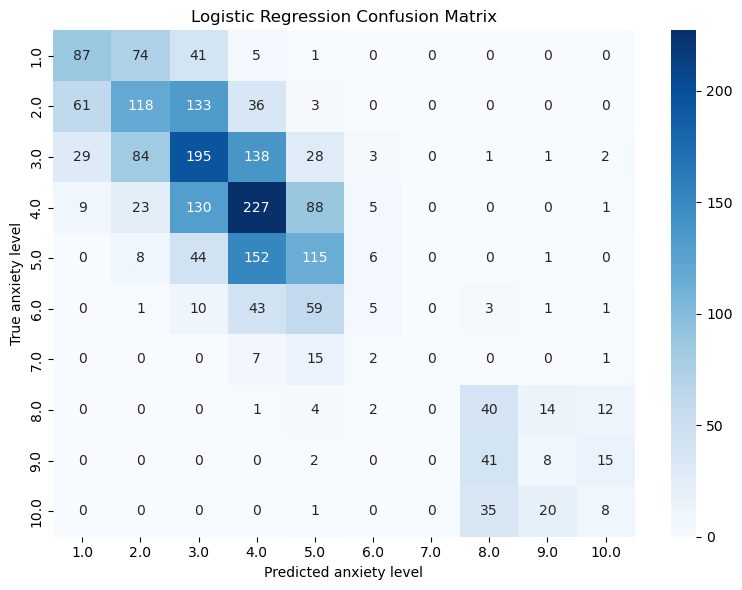

In [2]:
# classification_predictor.py

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# 0. Settings
DATA_PATH = 'anxiety.csv'
RANDOM_STATE = 42

# 1. Load & encode target
df = pd.read_csv(DATA_PATH)

# Original labels are 1–10; encode them to 0–9
le = LabelEncoder()
y = le.fit_transform(df['Anxiety Level (1-10)'])  # classes now 0–9
X = pd.get_dummies(df.drop('Anxiety Level (1-10)', axis=1), drop_first=True)
X = X.apply(pd.to_numeric)

# 2. Stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# 3. Define classifiers
models = {
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=500,
        random_state=RANDOM_STATE
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE
    ),
    'XGBoost': XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE
    )
}

# 4. 5‑fold CV on macro‑F1 (works now since y in {0..9})
cv_scores = {}
for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    cv_scores[name] = (scores.mean(), scores.std())
    print(f"{name} CV macro‑F1 = {scores.mean():.3f} ± {scores.std():.3f}")

# 5. Select & train best
best_name = max(cv_scores, key=lambda k: cv_scores[k][0])
print(f"\nBest model on CV: {best_name}\n")
best_model = models[best_name]
best_model.fit(X_train, y_train)

# 6. Evaluate on test set
y_pred_enc = best_model.predict(X_test)
acc   = accuracy_score(y_test, y_pred_enc)
f1    = f1_score(y_test, y_pred_enc, average='macro')
# map back to original 1–10 scale for reporting
y_test_orig = le.inverse_transform(y_test)
y_pred_orig = le.inverse_transform(y_pred_enc)

print(f"Test Accuracy    = {acc:.3f}")
print(f"Test macro‑F1     = {f1:.3f}\n")
print("Classification Report (original labels):\n")
print(classification_report(y_test_orig, y_pred_orig, digits=3))

# 7. Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred_enc)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True, fmt='d',
    xticklabels=le.classes_,  # shows 1–10
    yticklabels=le.classes_ ,
    cmap='Blues'
)
plt.xlabel('Predicted anxiety level')
plt.ylabel('True anxiety level')
plt.title(f'{best_name} Confusion Matrix')
plt.tight_layout()

# Save plot
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/confusion_matrix.png')
plt.show()


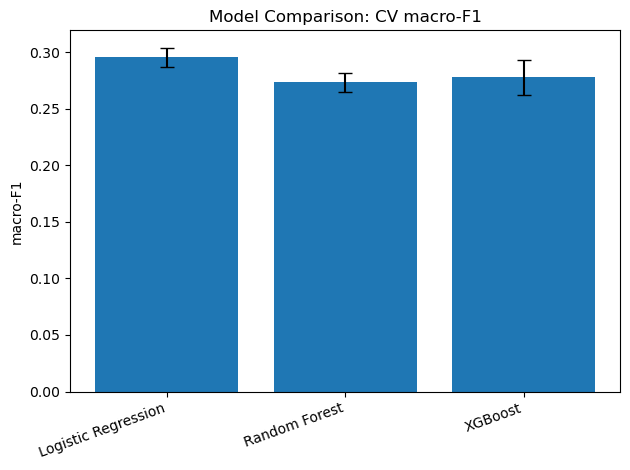

In [3]:
import matplotlib.pyplot as plt

# cv_scores is your dict: { 'Logistic Regression': (mean, std), … }
names = list(cv_scores.keys())
means = [cv_scores[n][0] for n in names]
stds  = [cv_scores[n][1] for n in names]

plt.figure()
plt.bar(names, means, yerr=stds, capsize=5)
plt.ylabel("macro‑F1")
plt.title("Model Comparison: CV macro‑F1")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.savefig('plots/cv_macro_f1_comparison.png')
plt.show()


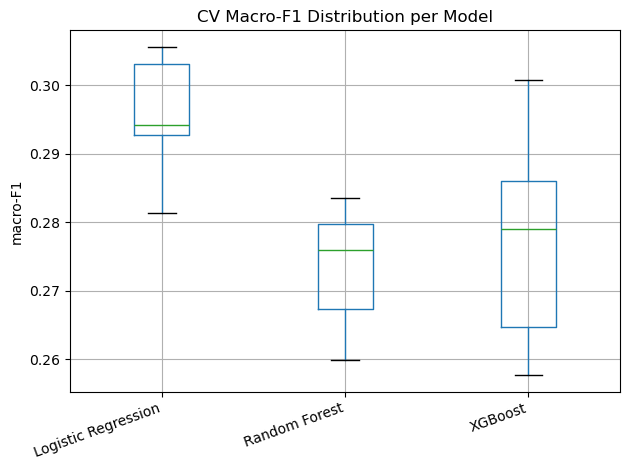

In [4]:
import pandas as pd

# re‑run cross_val_score to grab all fold scores
fold_scores = {
    name: cross_val_score(
        model, X_train, y_train,
        cv=5, scoring='f1_macro', n_jobs=-1
    )
    for name, model in models.items()
}
df_folds = pd.DataFrame(fold_scores)

plt.figure()
df_folds.boxplot()
plt.ylabel("macro‑F1")
plt.title("CV Macro‑F1 Distribution per Model")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.savefig('plots/cv_macro_f1_boxplot.png')
plt.show()


CV macro‑F1 scores for all variants:
----------------------------------------
LR (base)            0.295 ± 0.009
RF (base)            0.273 ± 0.009
XGB (base)           0.278 ± 0.015
LR (balanced)        0.287 ± 0.013
RF (balanced)        0.280 ± 0.008
LR + SMOTE           0.296 ± 0.011
RF + SMOTE           0.292 ± 0.018
XGB + SMOTE          0.288 ± 0.015

Best variant on CV: LR + SMOTE



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy   = 0.309
Test macro‑F1    = 0.273

Classification Report (1–10 labels):

              precision    recall  f1-score   support

         2.0      0.374     0.620     0.467       208
         3.0      0.332     0.342     0.337       351
         4.0      0.373     0.252     0.301       481
         5.0      0.376     0.296     0.331       483
         6.0      0.325     0.209     0.254       326
         7.0      0.206     0.325     0.252       123
         8.0      0.039     0.240     0.067        25
         9.0      0.221     0.233     0.227        73
        10.0      0.274     0.258     0.266        66
        11.0      0.194     0.281     0.229        64

    accuracy                          0.309      2200
   macro avg      0.271     0.306     0.273      2200
weighted avg      0.334     0.309     0.311      2200



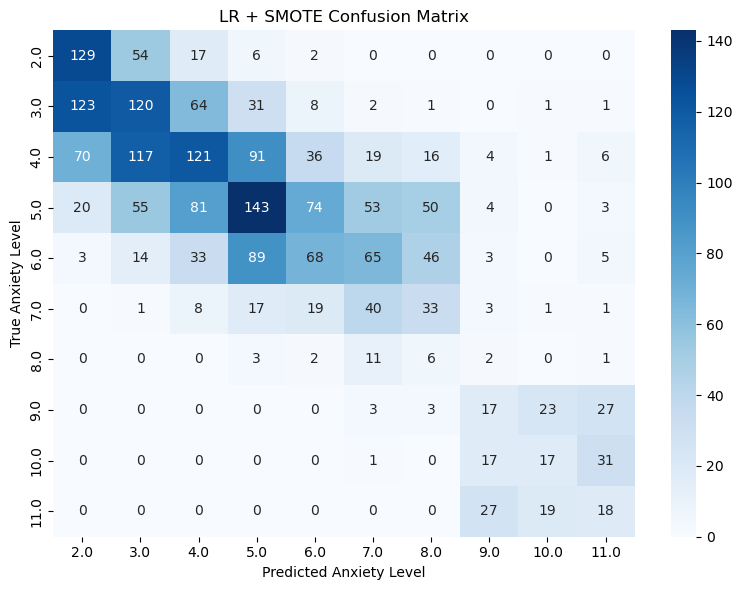

In [5]:
# classification_with_balance_and_smote.py

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# -- SETTINGS --
DATA_PATH = 'anxiety.csv'
RANDOM_STATE = 42

# -- 1. LOAD & ENCODE TARGET --
df = pd.read_csv(DATA_PATH)
le = LabelEncoder()
y = le.fit_transform(df['Anxiety Level (1-10)'])  # now 0..9
X = pd.get_dummies(df.drop('Anxiety Level (1-10)', axis=1), drop_first=True)
X = X.apply(pd.to_numeric)

# -- 2. STRATIFIED SPLIT --
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# -- 3. BASE MODELS --
base_models = {
    'LR': LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=500,
        random_state=RANDOM_STATE
    ),
    'RF': RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE
    ),
    'XGB': XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE
    )
}

# -- 4. BUILD VARIANTS --
variants = {}

# 4a. Base
for name, m in base_models.items():
    variants[f'{name} (base)'] = m

# 4b. class_weight='balanced'
variants['LR (balanced)'] = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
variants['RF (balanced)'] = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
# XGBClassifier does not accept class_weight directly, so we skip it here.

# 4c. SMOTE + base
for name, m in base_models.items():
    variants[f'{name} + SMOTE'] = Pipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', m)
    ])

# -- 5. CROSS‑VALIDATE ALL VARIANTS ON MACRO‑F1 --
print("CV macro‑F1 scores for all variants:")
print("-" * 40)
cv_results = {}
for name, model in variants.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name:<20} {scores.mean():.3f} ± {scores.std():.3f}")

# -- 6. SELECT BEST VARIANT & RETRAIN --
best_variant = max(cv_results, key=lambda k: cv_results[k][0])
print(f"\nBest variant on CV: {best_variant}\n")

best_model = variants[best_variant]
best_model.fit(X_train, y_train)

# -- 7. EVALUATE ON TEST SET --
y_pred_enc = best_model.predict(X_test)
acc   = accuracy_score(y_test, y_pred_enc)
f1    = f1_score(y_test, y_pred_enc, average='macro')

# Inverse-transform to original 1–10 for reporting
y_test_orig = le.inverse_transform(y_test) + 1
y_pred_orig = le.inverse_transform(y_pred_enc) + 1

print(f"Test Accuracy   = {acc:.3f}")
print(f"Test macro‑F1    = {f1:.3f}\n")
print("Classification Report (1–10 labels):\n")
print(classification_report(y_test_orig, y_pred_orig, digits=3))

# -- 8. CONFUSION MATRIX HEATMAP --
cm = confusion_matrix(y_test, y_pred_enc)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True, fmt='d',
    xticklabels=le.classes_ + 1,
    yticklabels=le.classes_ + 1,
    cmap='Blues'
)
plt.xlabel('Predicted Anxiety Level')
plt.ylabel('True Anxiety Level')
plt.title(f'{best_variant} Confusion Matrix')
plt.tight_layout()

os.makedirs('plots', exist_ok=True)
plt.savefig('plots/confusion_matrix.png')
plt.show()


In [6]:
df1=df.copy()

In [7]:
df['sleep_stress_int'] = df['Sleep Hours'] * df['Stress Level (1-10)']
df['caffeine_per_sleep'] = df['Caffeine Intake (mg/day)'] / df['Sleep Hours']
df['alc_per_activity'] = df['Alcohol Consumption (drinks/week)'] / (df['Physical Activity (hrs/week)'] + 1e-3)
df['therapy_efficiency'] = df['Therapy Sessions (per month)'] / (df['Stress Level (1-10)'] + 1e-3)
df['unhealthy_score'] = (
    (df['Smoking'] == 'Yes').astype(int)
  + (df['Alcohol Consumption (drinks/week)'] > 7).astype(int)
  + (df['Caffeine Intake (mg/day)'] > 400).astype(int)
)

df['symptom_severity'] = (
    (df['Dizziness'] == 'Yes').astype(int)
  + df['Sweating Level (1-5)']
  + (df['Recent Major Life Event'] != 'None').astype(int)
)
df['diet_activity_int'] = df['Diet Quality (1-10)'] * df['Physical Activity (hrs/week)']

bins = [0, 25, 35, 50, 100]
labels = ['<25', '25–35', '35–50', '50+']
df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels)

df['sleep_cat'] = pd.cut(
    df['Sleep Hours'],
    bins=[0,6,8,24],
    labels=['Short (<6h)','Normal (6–8h)','Long (>8h)']
)

df['activity_cat'] = pd.cut(
  df['Physical Activity (hrs/week)'],
  bins=[-1,2,5,100],
  labels=['Low','Moderate','High']
)


In [8]:
df

Age  Gender Occupation  Sleep Hours  Physical Activity (hrs/week)  \
0       29  Female     Artist          6.0                           2.7   
1       46   Other      Nurse          6.2                           5.7   
2       64    Male      Other          5.0                           3.7   
3       20  Female  Scientist          5.8                           2.8   
4       49  Female      Other          8.2                           2.3   
...    ...     ...        ...          ...                           ...   
10995   23  Female   Engineer          6.1                           3.1   
10996   50   Other    Teacher          6.6                           3.6   
10997   29    Male      Nurse          6.7                           6.9   
10998   53   Other     Artist          5.7                           2.7   
10999   56   Other    Teacher          6.1                           1.1   

       Caffeine Intake (mg/day)  Alcohol Consumption (drinks/week) Smoking  \
0                           181                                 10     Yes   
1                           200                                  8     Yes   
2                           117                                  4      No   
3                           360                                  6     Yes   
4                           247                                  4     Yes   
...                         ...                                ...     ...   
10995                       566                                  9     Yes   
10996                        64                                 17     Yes   
10997                       159                                 14      No   
10998                       248                                  8      No   
10999                       205                                 11      No   

      Family History of Anxiety  Stress Level (1-10)  ...  sleep_stress_int  \
0                            No                   10  ...              60.0   
1                           Yes                    1  ...               6.2   
2                           Yes                    1  ...               5.0   
3                            No                    4  ...              23.2   
4                            No                    1  ...               8.2   
...                         ...                  ...  ...               ...   
10995                        No                    8  ...              48.8   
10996                        No                    7  ...              46.2   
10997                        No                    8  ...              53.6   
10998                        No                    4  ...              22.8   
10999                        No                    1  ...               6.1   

       caffeine_per_sleep  alc_per_activity therapy_efficiency  \
0               30.166667          3.702332           0.299970   
1               32.258065          1.403263           1.998002   
2               23.400000          1.080789           0.999001   
3               62.068966          2.142092           0.000000   
4               30.121951          1.738375           0.999001   
...                   ...               ...                ...   
10995           92.786885          2.902290           0.124984   
10996            9.696970          4.720911           0.285673   
10997           23.731343          2.028691           0.249969   
10998           43.508772          2.961866           0.249938   
10999           33.606557          9.990917           1.998002   

      unhealthy_score  symptom_severity diet_activity_int  age_group  \
0                   2                 5              18.9      25–35   
1                   2                 4              45.6      35–50   
2                   0                 4               3.7        50+   
3                   1                 4               2.8        <25   
4                   1                 6               6

CV macro‑F1 scores for all variants:
----------------------------------------
LR (base)            0.264 ± 0.003
RF (base)            0.279 ± 0.008
XGB (base)           0.272 ± 0.004
LR (balanced)        0.263 ± 0.016
RF (balanced)        0.284 ± 0.014
LR + SMOTE           0.267 ± 0.016
RF + SMOTE           0.298 ± 0.005
XGB + SMOTE          0.281 ± 0.012

Best variant on CV: RF + SMOTE

Test Accuracy   = 0.350
Test macro‑F1    = 0.304

Classification Report (1–10 labels):

              precision    recall  f1-score   support

         2.0      0.372     0.476     0.418       208
         3.0      0.352     0.345     0.348       351
         4.0      0.341     0.297     0.318       481
         5.0      0.362     0.369     0.365       483
         6.0      0.381     0.402     0.391       326
         7.0      0.266     0.276     0.271       123
         8.0      0.000     0.000     0.000        25
         9.0      0.366     0.356     0.361        73
        10.0      0.288     0.227 

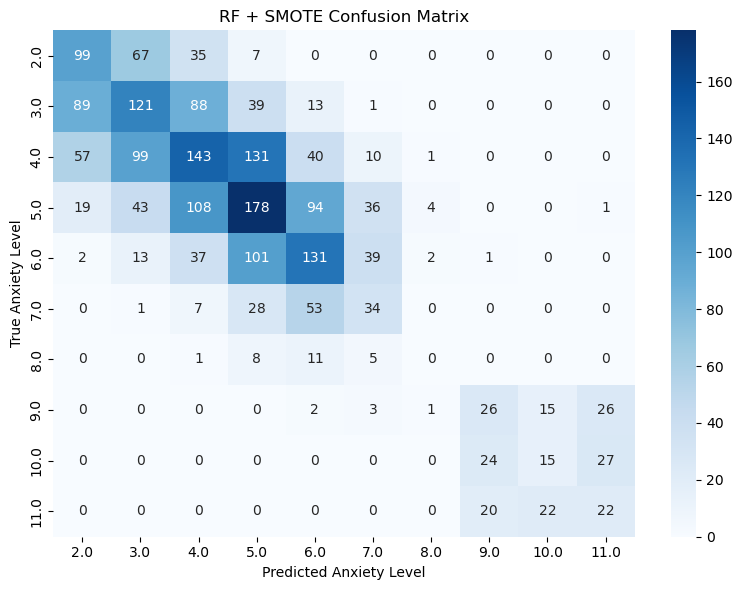

In [9]:
# classification_with_balance_and_smote.py

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

le = LabelEncoder()
y = le.fit_transform(df['Anxiety Level (1-10)'])  # now 0..9
X = pd.get_dummies(df.drop('Anxiety Level (1-10)', axis=1), drop_first=True)
X = X.apply(pd.to_numeric)

# -- 2. STRATIFIED SPLIT --
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# -- 3. BASE MODELS --
base_models = {
    'LR': LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=500,
        random_state=RANDOM_STATE
    ),
    'RF': RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE
    ),
    'XGB': XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE
    )
}

# -- 4. BUILD VARIANTS --
variants = {}

# 4a. Base
for name, m in base_models.items():
    variants[f'{name} (base)'] = m

# 4b. class_weight='balanced'
variants['LR (balanced)'] = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
variants['RF (balanced)'] = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
# XGBClassifier does not accept class_weight directly, so we skip it here.

# 4c. SMOTE + base
for name, m in base_models.items():
    variants[f'{name} + SMOTE'] = Pipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', m)
    ])

# -- 5. CROSS‑VALIDATE ALL VARIANTS ON MACRO‑F1 --
print("CV macro‑F1 scores for all variants:")
print("-" * 40)
cv_results = {}
for name, model in variants.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name:<20} {scores.mean():.3f} ± {scores.std():.3f}")

# -- 6. SELECT BEST VARIANT & RETRAIN --
best_variant = max(cv_results, key=lambda k: cv_results[k][0])
print(f"\nBest variant on CV: {best_variant}\n")

best_model = variants[best_variant]
best_model.fit(X_train, y_train)

# -- 7. EVALUATE ON TEST SET --
y_pred_enc = best_model.predict(X_test)
acc   = accuracy_score(y_test, y_pred_enc)
f1    = f1_score(y_test, y_pred_enc, average='macro')

# Inverse-transform to original 1–10 for reporting
y_test_orig = le.inverse_transform(y_test) + 1
y_pred_orig = le.inverse_transform(y_pred_enc) + 1

print(f"Test Accuracy   = {acc:.3f}")
print(f"Test macro‑F1    = {f1:.3f}\n")
print("Classification Report (1–10 labels):\n")
print(classification_report(y_test_orig, y_pred_orig, digits=3))

# -- 8. CONFUSION MATRIX HEATMAP --
cm = confusion_matrix(y_test, y_pred_enc)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True, fmt='d',
    xticklabels=le.classes_ + 1,
    yticklabels=le.classes_ + 1,
    cmap='Blues'
)
plt.xlabel('Predicted Anxiety Level')
plt.ylabel('True Anxiety Level')
plt.title(f'{best_variant} Confusion Matrix')
plt.tight_layout()

os.makedirs('plots', exist_ok=True)
plt.savefig('plots/confusion_matrix.png')
plt.show()


CV macro‑F1 scores for all variants:
----------------------------------------
LR (base)              0.830 ± 0.006
RF (base)              0.845 ± 0.005
XGB (base)             0.830 ± 0.006
LR (balanced)          0.826 ± 0.006
RF (balanced)          0.846 ± 0.007
LR + SMOTE             0.827 ± 0.007
RF + SMOTE             0.845 ± 0.006
XGB + SMOTE            0.833 ± 0.007

Best variant on CV: RF (balanced)

Test Accuracy   = 0.800
Test macro‑F1    = 0.852

Classification Report (Low/Medium/High):

              precision    recall  f1-score   support

        High      1.000     0.990     0.995       203
         Low      0.789     0.789     0.789      1040
      Medium      0.770     0.771     0.770       957

    accuracy                          0.800      2200
   macro avg      0.853     0.850     0.852      2200
weighted avg      0.800     0.800     0.800      2200



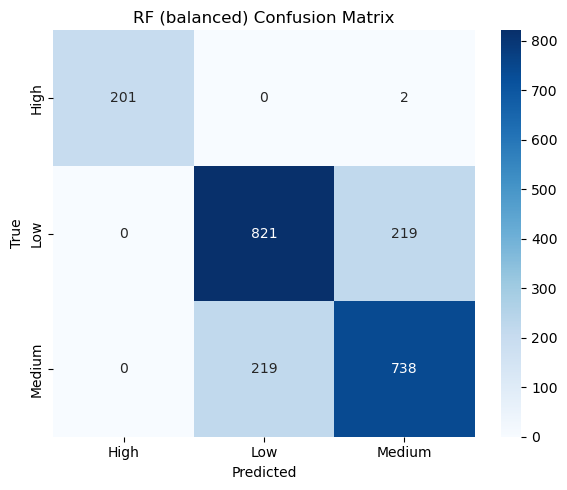

In [10]:
# classification_bins_balance_smote.py
# -------------------------------------------------
# 1) Bins Anxiety Level (1–10) into Low/Medium/High
# 2) Encodes features
# 3) Compares base, class_weight, and SMOTE variants
# 4) Picks best, evaluates on test set, shows confusion matrix
# -------------------------------------------------

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- SETTINGS ----------------
RANDOM_STATE = 42
BIN_BOUNDS   = [0, 3, 7, 10]                # (0,3], (3,7], (7,10]
BIN_LABELS   = ['Low', 'Medium', 'High']    # Your 3-class target

# --------------- 1. LOAD & BIN TARGET ---------------

# Create 3-class target
df['anxiety_bin'] = pd.cut(
    df['Anxiety Level (1-10)'],
    bins=BIN_BOUNDS,
    labels=BIN_LABELS,
    include_lowest=True,  # includes 0 if it ever occurs
    right=True            # 3 goes to Low, 3< x <=7 Medium, etc.
)

# Encode target to 0,1,2 for classifiers (and keep encoder to map back)
le = LabelEncoder()
y = le.fit_transform(df['anxiety_bin'])  # classes_: ['High', 'Low', 'Medium'] maybe; we'll use le.classes_

# Features: drop BOTH original and binned target columns from X
X = pd.get_dummies(df.drop(['Anxiety Level (1-10)', 'anxiety_bin'], axis=1), drop_first=True)
X = X.apply(pd.to_numeric)

# --------------- 2. STRATIFIED SPLIT -----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# --------------- 3. BASE MODELS ----------------------
base_models = {
    'LR': LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=500,
        random_state=RANDOM_STATE
    ),
    'RF': RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE
    ),
    'XGB': XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE
    )
}

# --------------- 4. BUILD VARIANTS -------------------
variants = {}

# 4a. Base
for name, m in base_models.items():
    variants[f'{name} (base)'] = m

# 4b. class_weight='balanced' (LR & RF only)
variants['LR (balanced)'] = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
variants['RF (balanced)'] = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
# XGB doesn't support class_weight directly.

# 4c. SMOTE + base (all three)
for name, m in base_models.items():
    variants[f'{name} + SMOTE'] = Pipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', m)
    ])

# --------------- 5. CV ON MACRO-F1 -------------------
print("CV macro‑F1 scores for all variants:")
print("-" * 40)
cv_results = {}
for name, model in variants.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name:<22} {scores.mean():.3f} ± {scores.std():.3f}")

# --------------- 6. PICK BEST & RETRAIN --------------
best_variant = max(cv_results, key=lambda k: cv_results[k][0])
print(f"\nBest variant on CV: {best_variant}\n")

best_model = variants[best_variant]
best_model.fit(X_train, y_train)

# --------------- 7. TEST EVALUATION ------------------
y_pred_enc = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_enc)
f1  = f1_score(y_test, y_pred_enc, average='macro')

# Map back to Low/Medium/High strings
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred_enc)

print(f"Test Accuracy   = {acc:.3f}")
print(f"Test macro‑F1    = {f1:.3f}\n")
print("Classification Report (Low/Medium/High):\n")
print(classification_report(y_test_str, y_pred_str, digits=3))

# --------------- 8. CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test, y_pred_enc)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'{best_variant} Confusion Matrix')
plt.tight_layout()

os.makedirs('plots', exist_ok=True)
plt.savefig('plots/confusion_matrix_bins.png')
plt.show()


In [11]:
y

array([2, 1, 1, ..., 2, 2, 1])

In [12]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(best_model, X_test, y_test,
                              scoring='f1_macro', n_repeats=10, n_jobs=-1,
                              random_state=42)
pi = (pd.Series(perm.importances_mean, index=X_test.columns)
        .sort_values(ascending=False))
print(pi.head(20))
pi.to_csv('plots/permutation_importance.csv')


Stress Level (1-10)             0.249880
Therapy Sessions (per month)    0.196310
Diet Quality (1-10)             0.087037
Heart Rate (bpm)                0.045559
sleep_stress_int                0.027892
Sleep Hours                     0.012817
diet_activity_int               0.003090
Sweating Level (1-5)            0.001687
symptom_severity                0.001185
age_group_25–35                 0.000758
caffeine_per_sleep              0.000717
Occupation_Musician             0.000393
age_group_50+                   0.000355
Occupation_Doctor               0.000233
Occupation_Teacher              0.000194
Occupation_Other                0.000139
Recent Major Life Event_Yes     0.000086
Occupation_Athlete              0.000044
Medication_Yes                  0.000041
Occupation_Student             -0.000046
dtype: float64


In [13]:
from sklearn.metrics import f1_score
import copy

base_f1 = f1_score(y_test, best_model.predict(X_test), average='macro')
drops = {}
for col in X_train.columns:
    X_tr_ = X_train.drop(columns=[col])
    X_te_ = X_test.drop(columns=[col])
    model_ = copy.deepcopy(best_model).fit(X_tr_, y_train)
    f1_ = f1_score(y_test, model_.predict(X_te_), average='macro')
    drops[col] = base_f1 - f1_

dc_importance = pd.Series(drops).sort_values(ascending=False)
print(dc_importance.head(20))
dc_importance.to_csv('plots/dropcol_importance.csv')


caffeine_per_sleep               0.000972
Occupation_Chef                  0.000907
Stress Level (1-10)              0.000253
Occupation_Nurse                -0.000080
Gender_Other                    -0.000090
activity_cat_Moderate           -0.000090
symptom_severity                -0.000419
unhealthy_score                 -0.000693
Family History of Anxiety_Yes   -0.000704
sleep_stress_int                -0.000748
Occupation_Other                -0.001033
Recent Major Life Event_Yes     -0.001107
Gender_Male                     -0.001384
Occupation_Lawyer               -0.001416
Diet Quality (1-10)             -0.001454
Occupation_Musician             -0.001745
Occupation_Scientist            -0.001765
Therapy Sessions (per month)    -0.001797
Medication_Yes                  -0.001843
activity_cat_High               -0.002104
dtype: float64


CV macro‑F1 scores for all variants:
----------------------------------------
LR (base)                0.830 ± 0.006
RF (base)                0.845 ± 0.005
XGB (base)               0.830 ± 0.006
LR (balanced)            0.826 ± 0.006
RF (balanced)            0.846 ± 0.007
LR + SMOTE               0.827 ± 0.007
RF + SMOTE               0.845 ± 0.006
XGB + SMOTE              0.833 ± 0.007
LR + BSMOTE              0.818 ± 0.003
RF + BSMOTE              0.845 ± 0.006
XGB + BSMOTE             0.833 ± 0.007

Best variant on CV: RF (balanced)

Test Accuracy   = 0.800
Test macro‑F1    = 0.852

Classification Report (Low/Medium/High):

              precision    recall  f1-score   support

        High      1.000     0.990     0.995       203
         Low      0.789     0.789     0.789      1040
      Medium      0.770     0.771     0.770       957

    accuracy                          0.800      2200
   macro avg      0.853     0.850     0.852      2200
weighted avg      0.800     0.800     0

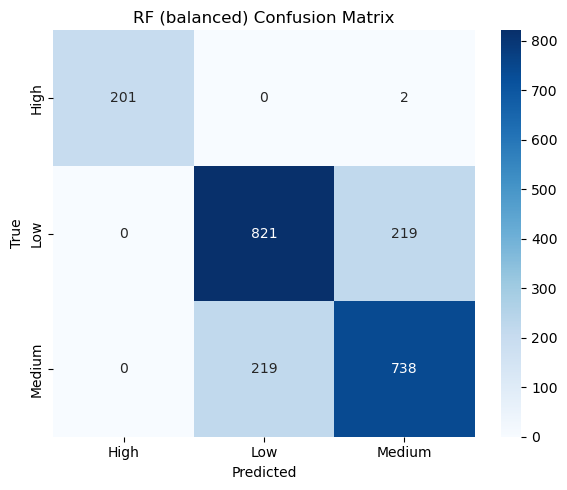

In [14]:
# classification_bins_balance_smote.py
# -------------------------------------------------
# 1) Bins Anxiety Level (1–10) into Low/Medium/High
# 2) Encodes features
# 3) Compares base, class_weight, SMOTE, and BorderlineSMOTE variants
# 4) Picks best, evaluates on test set, shows confusion matrix
# -------------------------------------------------

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- SETTINGS ----------------
RANDOM_STATE = 42
BIN_BOUNDS   = [0, 3, 7, 10]                # (0,3], (3,7], (7,10]
BIN_LABELS   = ['Low', 'Medium', 'High']    # 3-class target

# --------------- 1. LOAD & BIN TARGET ---------------
# df assumed to be already loaded and engineered above this script.
# If not, uncomment next line and load your CSV:
# df = pd.read_csv('anxiety.csv')

df['anxiety_bin'] = pd.cut(
    df['Anxiety Level (1-10)'],
    bins=BIN_BOUNDS,
    labels=BIN_LABELS,
    include_lowest=True,
    right=True
)

# Encode target to 0,1,2
le = LabelEncoder()
y = le.fit_transform(df['anxiety_bin'])

# Features: drop both original and binned target
X = pd.get_dummies(df.drop(['Anxiety Level (1-10)', 'anxiety_bin'], axis=1), drop_first=True)
X = X.apply(pd.to_numeric)

# --------------- 2. STRATIFIED SPLIT -----------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# --------------- 3. BASE MODELS ----------------------
base_models = {
    'LR': LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=500,
        random_state=RANDOM_STATE
    ),
    'RF': RandomForestClassifier(
        n_estimators=200,
        random_state=RANDOM_STATE
    ),
    'XGB': XGBClassifier(
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=RANDOM_STATE
    )
}

# --------------- 4. BUILD VARIANTS -------------------
variants = {}

# 4a. Base
for name, m in base_models.items():
    variants[f'{name} (base)'] = m

# 4b. class_weight='balanced' (LR & RF only)
variants['LR (balanced)'] = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
variants['RF (balanced)'] = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
# XGB doesn't support class_weight directly.

# 4c. SMOTE + base
for name, m in base_models.items():
    variants[f'{name} + SMOTE'] = Pipeline([
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('model', m)
    ])

# 4d. BorderlineSMOTE + base
# (If you're on imblearn >=0.10, BorderlineSMOTE(kind='borderline-1') was removed.
# Default behavior is type1. Adjust params if needed.)
for name, m in base_models.items():
    variants[f'{name} + BSMOTE'] = Pipeline([
        ('bsmote', BorderlineSMOTE(random_state=RANDOM_STATE)),
        ('model', m)
    ])

# --------------- 5. CV ON MACRO-F1 -------------------
print("CV macro‑F1 scores for all variants:")
print("-" * 40)
cv_results = {}
for name, model in variants.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name:<24} {scores.mean():.3f} ± {scores.std():.3f}")

# --------------- 6. PICK BEST & RETRAIN --------------
best_variant = max(cv_results, key=lambda k: cv_results[k][0])
print(f"\nBest variant on CV: {best_variant}\n")

best_model = variants[best_variant]
best_model.fit(X_train, y_train)

# --------------- 7. TEST EVALUATION ------------------
y_pred_enc = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred_enc)
f1  = f1_score(y_test, y_pred_enc, average='macro')

# Map back to class strings
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred_enc)

print(f"Test Accuracy   = {acc:.3f}")
print(f"Test macro‑F1    = {f1:.3f}\n")
print("Classification Report (Low/Medium/High):\n")
print(classification_report(y_test_str, y_pred_str, digits=3))

# --------------- 8. CONFUSION MATRIX -----------------
cm = confusion_matrix(y_test, y_pred_enc)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=le.classes_,
    yticklabels=le.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'{best_variant} Confusion Matrix')
plt.tight_layout()

os.makedirs('plots', exist_ok=True)
plt.savefig('plots/confusion_matrix_bins.png')
plt.show()


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Map encoded ids to names (0:High, 1:Low, 2:Medium)
id_to_lab = {i: lab for i, lab in enumerate(le.classes_)}  # {'High':0,'Low':1,'Medium':2} but inverted
lab_to_id = {v: k for k, v in id_to_lab.items()}           # {'High':0,'Low':1,'Medium':2}

# Custom scorer: macro-F1 on ONLY Low & Medium
def f1_low_med(y_true, y_pred):
    mask = np.isin(y_true, [lab_to_id['Low'], lab_to_id['Medium']])
    return f1_score(y_true[mask], y_pred[mask], average='macro')

f1_low_med_scorer = make_scorer(f1_low_med, greater_is_better=True)

# Weight grid: lower weight for High (already great), sweep Low/Medium up
w_high   = [0.5, 1.0]
w_low    = [1.0, 1.5, 2.0, 3.0]
w_medium = [1.0, 1.5, 2.0, 3.0]

param_grid = []
for wh in w_high:
    for wl in w_low:
        for wm in w_medium:
            param_grid.append({
                'class_weight': [{lab_to_id['High']: wh,
                                  lab_to_id['Low']: wl,
                                  lab_to_id['Medium']: wm}],
                'n_estimators': [300],             # fix others for speed; tune later
                'max_depth': [None, 15, 25]        # small extra search
            })

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    scoring=f1_low_med_scorer,   # focus on Low/Medium
    cv=5,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("CV f1_low_med:", grid.best_score_)

best_rf_weighted = grid.best_estimator_


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best params: {'class_weight': {0: 0.5, 1: 3.0, 2: 3.0}, 'max_depth': 15, 'n_estimators': 300}
CV f1_low_med: 0.6190523842661678


Test macro‑F1 (all 3 classes): 0.8516991869025775
Test macro‑F1 (Low & Medium): 0.5228827342943386
              precision    recall  f1-score   support

        High      0.990     0.985     0.988       203
         Low      0.799     0.785     0.792      1040
      Medium      0.768     0.784     0.776       957

    accuracy                          0.803      2200
   macro avg      0.852     0.851     0.852      2200
weighted avg      0.803     0.803     0.803      2200



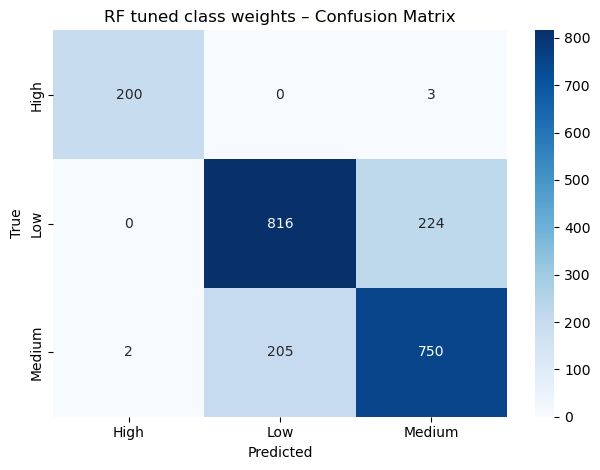

In [16]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Use the model you got from GridSearchCV
best_rf_weighted = grid.best_estimator_

y_pred_enc = best_rf_weighted.predict(X_test)

# Overall metrics
print("Test macro‑F1 (all 3 classes):", f1_score(y_test, y_pred_enc, average='macro'))

# Focused metric (Low+Medium only)
low_id    = np.where(le.classes_ == 'Low')[0][0]
med_id    = np.where(le.classes_ == 'Medium')[0][0]
mask_lm   = np.isin(y_test, [low_id, med_id])
print("Test macro‑F1 (Low & Medium):",
      f1_score(y_test[mask_lm], y_pred_enc[mask_lm], average='macro'))

# Human-readable report
y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred_enc)
print(classification_report(y_test_str, y_pred_str, digits=3))

# Confusion matrix (ensure orders)
order = ['High','Low','Medium']
order_ids = [np.where(le.classes_==c)[0][0] for c in order]
cm = confusion_matrix(y_test, y_pred_enc, labels=order_ids)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=order, yticklabels=order)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('RF tuned class weights – Confusion Matrix')
plt.tight_layout()
plt.show()


In [18]:
proba = best_rf_weighted.predict_proba(X_test)
# columns aligned with le.classes_
idx_high = np.where(le.classes_=='High')[0][0]
idx_low  = np.where(le.classes_=='Low')[0][0]
idx_med  = np.where(le.classes_=='Medium')[0][0]

def predict_with_threshold(p, delta=0.05):
    # If Medium prob only slightly above Low, flip to Low to boost its recall
    if (p[idx_med] - p[idx_low]) < delta:
        return idx_low
    return np.argmax(p)

y_pred_custom = np.array([predict_with_threshold(p, delta=0.05) for p in proba])
print("Custom threshold macro‑F1:",
      f1_score(y_test, y_pred_custom, average='macro'))


Custom threshold macro‑F1: 0.6408463468320028


In [19]:
# baseline (argmax):
baseline_pred = best_rf_weighted.predict(X_test)
print("Baseline macro‑F1:", f1_score(y_test, baseline_pred, average='macro'))

# focus only on Low+Medium if that's your goal:
lm_mask = np.isin(y_test, [lab_to_id['Low'], lab_to_id['Medium']])
print("Baseline L+M macro‑F1:",
      f1_score(y_test[lm_mask], baseline_pred[lm_mask], average='macro'))

print("Custom L+M macro‑F1:",
      f1_score(y_test[lm_mask], y_pred_custom[lm_mask], average='macro'))


Baseline macro‑F1: 0.8516991869025775
Baseline L+M macro‑F1: 0.5228827342943386
Custom L+M macro‑F1: 0.5216013082425727


In [21]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# ids
hi, lo, me = high_id, low_id, med_id

# Train High-vs-Other
y_high = (y_train == hi).astype(int)
clf_high = RandomForestClassifier(random_state=42).fit(X_train, y_high)

# Train Low-vs-Medium on remaining
mask_lm = y_train != hi
y_lm = (y_train[mask_lm] == lo).astype(int)
clf_lm = RandomForestClassifier(random_state=42).fit(X_train[mask_lm], y_lm)

# Predict
p_high = clf_high.predict(X_test)
pred_final = np.full(len(y_test), fill_value=me)  # default Medium
pred_final[p_high==1] = hi   # High
idx_rest = np.where(p_high==0)[0]
pred_final[idx_rest] = np.where(clf_lm.predict(X_test.iloc[idx_rest])==1, lo, me)


Macro-F1 (all classes): 0.855
Macro-F1 (Low & Medium only): 0.788

Classification report:
               precision    recall  f1-score   support

        High      1.000     0.985     0.993       203
         Low      0.806     0.781     0.793      1040
      Medium      0.767     0.795     0.781       957

    accuracy                          0.806      2200
   macro avg      0.858     0.854     0.855      2200
weighted avg      0.807     0.806     0.806      2200



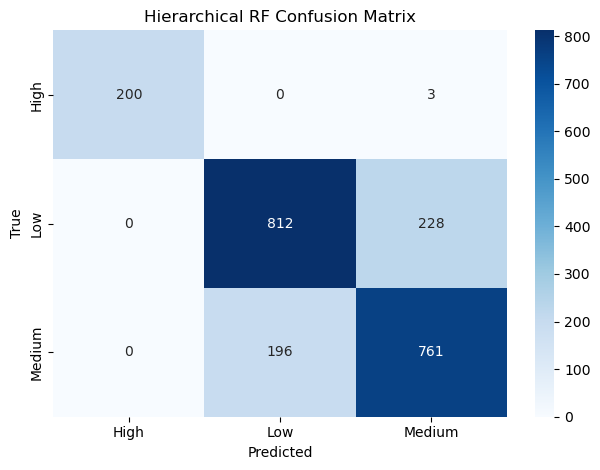

In [23]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# ids from earlier
hi, lo, me = high_id, low_id, med_id

# Evaluate
macro_f1 = f1_score(y_test, pred_final, average='macro')
lm_mask  = np.isin(y_test, [lo, me])
lm_f1    = f1_score(y_test[lm_mask], pred_final[lm_mask], average='macro')

print(f"Macro-F1 (all classes): {macro_f1:.3f}")
print(f"Macro-F1 (Low & Medium only): {lm_f1:.3f}")

y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(pred_final)
print("\nClassification report:\n", classification_report(y_test_str, y_pred_str, digits=3))

# Confusion matrix heatmap
order      = ['High', 'Low', 'Medium']
order_ids  = [np.where(le.classes_ == c)[0][0] for c in order]
cm         = confusion_matrix(y_test, pred_final, labels=order_ids)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=order, yticklabels=order)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Hierarchical RF Confusion Matrix")
plt.tight_layout()
plt.show()


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best High-vs-Rest params: {'class_weight': {0: 1, 1: 3}, 'max_depth': 10, 'n_estimators': 200} F1: 0.9844313554460044
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best Low-vs-Medium params: {'class_weight': {0: 1, 1: 2}, 'max_depth': 10, 'n_estimators': 400} F1: 0.7938996111280402
Hierarchical RF (tuned weights) -> Macro-F1(all): 0.846 | Macro-F1(L+M): 0.774

Classification report:
               precision    recall  f1-score   support

        High      1.000     0.985     0.993       203
         Low      0.753     0.849     0.798      1040
      Medium      0.807     0.697     0.748       957

    accuracy                          0.795      2200
   macro avg      0.853     0.844     0.846      2200
weighted avg      0.799     0.795     0.794      2200



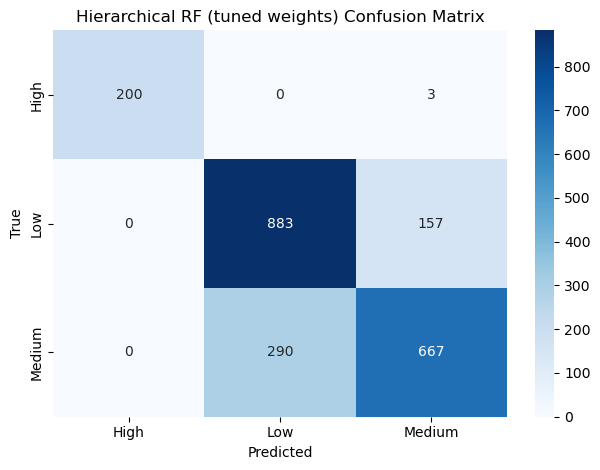

Hierarchical RF (BSMOTE stage2) -> Macro-F1(all): 0.855 | Macro-F1(L+M): 0.785

Classification report:
               precision    recall  f1-score   support

        High      1.000     0.990     0.995       203
         Low      0.786     0.809     0.797      1040
      Medium      0.784     0.761     0.772       957

    accuracy                          0.805      2200
   macro avg      0.857     0.853     0.855      2200
weighted avg      0.805     0.805     0.804      2200



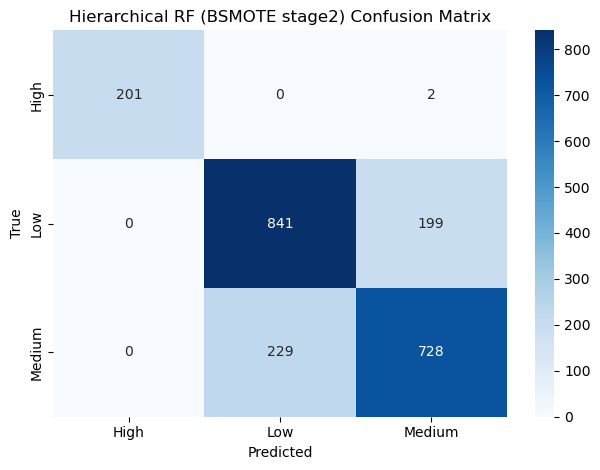

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

Best threshold for Low (vs Medium) = 0.460, macro-F1=0.864
Hierarchical (calibrated + threshold) -> Macro-F1(all): 0.864 | Macro-F1(L+M): 0.801

Classification report:
               precision    recall  f1-score   support

        High      1.000     0.985     0.993       203
         Low      0.801     0.823     0.812      1040
      Medium      0.799     0.778     0.789       957

    accuracy                          0.819      2200
   macro avg      0.867     0.862     0.864      2200
weighted avg      0.819     0.819     0.819      2200



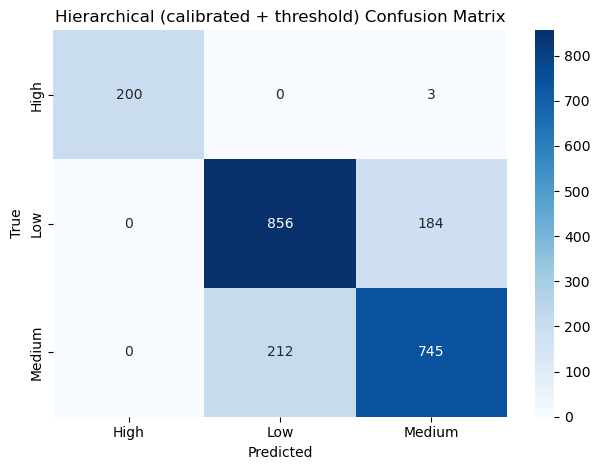

In [25]:
# hierarchy_experiments.py
import numpy as np
import pandas as pd
from collections import defaultdict

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, classification_report, confusion_matrix, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------
# 0. Assume you ALREADY have:
#   df  -> your engineered dataframe
#   df['anxiety_bin'] with Low/Medium/High
# --------------------------------------------------

# --- Encode target ---
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['anxiety_bin'])  # 0/1/2 in order of le.classes_
X = pd.get_dummies(df.drop(['Anxiety Level (1-10)', 'anxiety_bin'], axis=1), drop_first=True).apply(pd.to_numeric)

# Order ids by class names for convenience
hi_id = np.where(le.classes_ == 'High')[0][0]
lo_id = np.where(le.classes_ == 'Low')[0][0]
me_id = np.where(le.classes_ == 'Medium')[0][0]

from sklearn.model_selection import train_test_split
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# --------------------------------------------------
# Helper: Hierarchical two-stage wrapper
# --------------------------------------------------
class HierarchicalTwoStage:
    """
    Stage 1: hi vs not-hi
    Stage 2: lo vs me (only on not-hi)
    """
    def __init__(self, clf_hi, clf_lm, hi_id, lo_id, me_id):
        self.clf_hi = clf_hi
        self.clf_lm = clf_lm
        self.hi_id, self.lo_id, self.me_id = hi_id, lo_id, me_id

    def fit(self, X, y):
        y_hi = (y == self.hi_id).astype(int)
        self.clf_hi.fit(X, y_hi)

        mask_lm = (y != self.hi_id)
        y_lm = (y[mask_lm] == self.lo_id).astype(int)
        self.clf_lm.fit(X[mask_lm], y_lm)
        return self

    def predict(self, X):
        p_hi = self.clf_hi.predict(X)
        pred = np.full(len(X), self.me_id)  # default Medium
        pred[p_hi == 1] = self.hi_id

        idx_rest = np.where(p_hi == 0)[0]
        lm_pred = self.clf_lm.predict(X.iloc[idx_rest])
        pred[idx_rest] = np.where(lm_pred == 1, self.lo_id, self.me_id)
        return pred

    def predict_proba(self, X):
        # optional, only if you need global proba. Not implemented here.
        raise NotImplementedError

# --------------------------------------------------
# 1) Stage-specific tuning (RF + manual weights)
# --------------------------------------------------
def tune_stage_models():
    # Stage 1 (High vs Rest)
    y_hi = (y_train == hi_id).astype(int)
    rf_hi = RandomForestClassifier(random_state=RANDOM_STATE)

    grid_hi = GridSearchCV(
        rf_hi,
        param_grid={
            'n_estimators': [200, 400],
            'max_depth': [10, 15, None],
            'class_weight': [None, {0:1, 1:2}, {0:1, 1:3}]  # weight "high" or "not-high"
        },
        scoring='f1',  # binary F1 for hi/not-hi
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_hi.fit(X_train, y_hi)
    best_hi = grid_hi.best_estimator_
    print("Best High-vs-Rest params:", grid_hi.best_params_, "F1:", grid_hi.best_score_)

    # Stage 2 (Low vs Medium) with manual weights
    mask_lm = (y_train != hi_id)
    y_lm = (y_train[mask_lm] == lo_id).astype(int)

    # we’ll try RF first
    rf_lm = RandomForestClassifier(random_state=RANDOM_STATE)
    weight_grid = [
        None,
        {0:1, 1:1},
        {0:1, 1:2},
        {0:1, 1:3},
        {0:1, 1:4},
    ]
    grid_lm = GridSearchCV(
        rf_lm,
        param_grid={
            'n_estimators': [200, 400],
            'max_depth': [10, 15, None],
            'class_weight': weight_grid
        },
        scoring='f1',  # binary F1 for low vs medium
        cv=5,
        n_jobs=-1,
        verbose=1
    )
    grid_lm.fit(X_train[mask_lm], y_lm)
    best_lm = grid_lm.best_estimator_
    print("Best Low-vs-Medium params:", grid_lm.best_params_, "F1:", grid_lm.best_score_)

    return best_hi, best_lm

# --------------------------------------------------
# 2) BorderlineSMOTE on Stage 2
# --------------------------------------------------
def build_stage2_with_bsmote(base_model):
    return Pipeline([
        ('bsmote', BorderlineSMOTE(random_state=RANDOM_STATE)),
        ('model', base_model)
    ])

# --------------------------------------------------
# 3) Calibrate Stage 2 probabilities + threshold sweep
# --------------------------------------------------
def calibrate_and_threshold(clf_hi, clf_lm_base):
    # Fit hi/not-hi
    y_hi = (y_train == hi_id).astype(int)
    clf_hi.fit(X_train, y_hi)

    # Fit LM base, calibrate
    mask_lm = (y_train != hi_id)
    y_lm = (y_train[mask_lm] == lo_id).astype(int)

    calib = CalibratedClassifierCV(clf_lm_base, method='isotonic', cv=5)
    calib.fit(X_train[mask_lm], y_lm)

    # Predict path
    p_hi = clf_hi.predict(X_test)
    pred_final = np.full(len(y_test), me_id)
    pred_final[p_hi == 1] = hi_id
    idx_rest = np.where(p_hi == 0)[0]

    proba_lm = calib.predict_proba(X_test.iloc[idx_rest])  # [:,1] = prob Low
    # Sweep threshold for Low vs Medium
    thresholds = np.linspace(0.3, 0.7, 41)
    best_t, best_score = 0.5, -1
    for t in thresholds:
        tmp_pred = pred_final.copy()
        tmp_pred[idx_rest] = np.where(proba_lm[:,1] >= t, lo_id, me_id)
        score = f1_score(y_test, tmp_pred, average='macro')
        if score > best_score:
            best_score, best_t = score, t
    print(f"Best threshold for Low (vs Medium) = {best_t:.3f}, macro-F1={best_score:.3f}")

    # Final prediction
    pred_final[idx_rest] = np.where(proba_lm[:,1] >= best_t, lo_id, me_id)
    return pred_final

# --------------------------------------------------
# 4) Evaluation helper
# --------------------------------------------------
def evaluate(pred, title="Model"):
    macro = f1_score(y_test, pred, average='macro')
    lm_mask = np.isin(y_test, [lo_id, me_id])
    lm_macro = f1_score(y_test[lm_mask], pred[lm_mask], average='macro')
    print(f"{title} -> Macro-F1(all): {macro:.3f} | Macro-F1(L+M): {lm_macro:.3f}")

    y_test_str = le.inverse_transform(y_test)
    y_pred_str = le.inverse_transform(pred)
    print("\nClassification report:\n", classification_report(y_test_str, y_pred_str, digits=3))

    # Confusion matrix
    order = ['High','Low','Medium']
    order_ids = [np.where(le.classes_==c)[0][0] for c in order]
    cm = confusion_matrix(y_test, pred, labels=order_ids)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=order, yticklabels=order)
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

# --------------------------------------------------
# ---- RUN EXPERIMENTS ----
# Choose what you want to run by toggling these booleans
RUN_TUNING          = True
RUN_BSMOTE_STAGE2   = True
RUN_CALIB_THRESHOLD = True   # requires a base stage2 model

if RUN_TUNING:
    best_hi, best_lm = tune_stage_models()
    hier_tuned = HierarchicalTwoStage(best_hi, best_lm, hi_id, lo_id, me_id).fit(X_train, y_train)
    pred_tuned = hier_tuned.predict(X_test)
    evaluate(pred_tuned, "Hierarchical RF (tuned weights)")

if RUN_BSMOTE_STAGE2:
    # Use tuned hi model (or default) + BSMOTE on stage2
    hi_model = RandomForestClassifier(n_estimators=300, max_depth=15, random_state=RANDOM_STATE,
                                      class_weight={0:1,1:2})  # dummy; replace with best_hi if already tuned
    hi_model.fit(X_train, (y_train == hi_id).astype(int))

    # Build LM with BSMOTE + RF
    lm_pipe = build_stage2_with_bsmote(RandomForestClassifier(
        n_estimators=300, max_depth=15, random_state=RANDOM_STATE,
        class_weight={0:1,1:3}  # low vs medium weights
    ))
    mask_lm = (y_train != hi_id)
    lm_pipe.fit(X_train[mask_lm], (y_train[mask_lm] == lo_id).astype(int))

    # Predict
    p_hi = hi_model.predict(X_test)
    pred_bsm = np.full(len(y_test), me_id)
    pred_bsm[p_hi==1] = hi_id
    idx_rest = np.where(p_hi==0)[0]
    pred_bsm[idx_rest] = np.where(lm_pipe.predict(X_test.iloc[idx_rest])==1, lo_id, me_id)

    evaluate(pred_bsm, "Hierarchical RF (BSMOTE stage2)")

if RUN_CALIB_THRESHOLD:
    # Need a base LM model to calibrate. Use LogisticRegression for stage2 to be different:
    lm_base = LogisticRegression(max_iter=3000, random_state=RANDOM_STATE)
    pred_calib = calibrate_and_threshold(
        clf_hi=RandomForestClassifier(n_estimators=300, max_depth=15, random_state=RANDOM_STATE),
        clf_lm_base=lm_base
    )
    evaluate(pred_calib, "Hierarchical (calibrated + threshold)")


CV macro‑F1 scores for all variants:
---------------------------------------------
LR (base)                0.845 ± 0.009
RF (base)                0.845 ± 0.006
XGB (base)               0.833 ± 0.006
LR (balanced)            0.837 ± 0.010
RF (balanced)            0.846 ± 0.005
LR + SMOTE               0.840 ± 0.008
RF + SMOTE               0.848 ± 0.004
XGB + SMOTE              0.833 ± 0.005
LR + BSMOTE              0.840 ± 0.007
RF + BSMOTE              0.848 ± 0.005
XGB + BSMOTE             0.831 ± 0.003

Best variant on CV: RF + BSMOTE

Test Accuracy   = 0.810
Test macro‑F1    = 0.859

Classification Report (Low/Medium/High):

              precision    recall  f1-score   support

        High      1.000     0.990     0.995       203
         Low      0.811     0.781     0.796      1040
      Medium      0.770     0.803     0.786       957

    accuracy                          0.810      2200
   macro avg      0.860     0.858     0.859      2200
weighted avg      0.810     0.810   

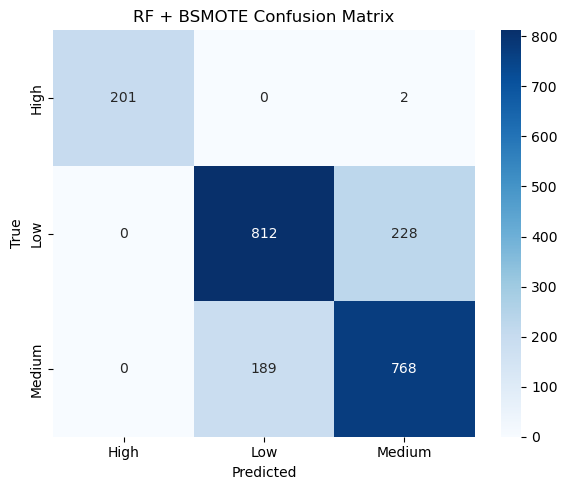

In [26]:
# classification_bins_balance_smote_scaled.py
# -------------------------------------------------
# 1) (Optional) add engineered features
# 2) Bin Anxiety Level (1–10) into Low/Medium/High
# 3) Encode features
# 4) Compare base, class_weight, SMOTE, BorderlineSMOTE variants
#    with scaled LogisticRegression pipelines
# 5) Pick best, evaluate on test set, confusion matrix
# 6) (Optional) Hierarchical model (High vs rest, Low vs Medium)
# -------------------------------------------------

import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, make_scorer
)

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
BIN_BOUNDS   = [0, 3, 7, 10]
BIN_LABELS   = ['Low', 'Medium', 'High']

#--------------------------------------------------
# 0. (Optional) Feature engineering helper
#--------------------------------------------------
def add_features(df):
    df['sleep_stress_int'] = df['Sleep Hours'] * df['Stress Level (1-10)']
    df['caffeine_per_sleep'] = df['Caffeine Intake (mg/day)'] / df['Sleep Hours']
    df['alc_per_activity'] = df['Alcohol Consumption (drinks/week)'] / (df['Physical Activity (hrs/week)'] + 1e-3)
    df['therapy_efficiency'] = df['Therapy Sessions (per month)'] / (df['Stress Level (1-10)'] + 1e-3)
    df['unhealthy_score'] = (
        (df['Smoking'] == 'Yes').astype(int)
      + (df['Alcohol Consumption (drinks/week)'] > 7).astype(int)
      + (df['Caffeine Intake (mg/day)'] > 400).astype(int)
    )
    df['symptom_severity'] = (
        (df['Dizziness'] == 'Yes').astype(int)
      + df['Sweating Level (1-5)']
      + (df['Recent Major Life Event'] != 'None').astype(int)
    )
    df['diet_activity_int'] = df['Diet Quality (1-10)'] * df['Physical Activity (hrs/week)']

    bins = [0, 25, 35, 50, 100]
    labels = ['<25', '25–35', '35–50', '50+']
    df['age_group'] = pd.cut(df['Age'], bins=bins, labels=labels)

    df['sleep_cat'] = pd.cut(df['Sleep Hours'], bins=[0,6,8,24],
                             labels=['Short (<6h)','Normal (6–8h)','Long (>8h)'])
    df['activity_cat'] = pd.cut(df['Physical Activity (hrs/week)'],
                                bins=[-1,2,5,100],
                                labels=['Low','Moderate','High'])
    return df

#--------------------------------------------------
# 1. Load data (ensure your CSV path)
#--------------------------------------------------
df = pd.read_csv('anxiety.csv')
# df = add_features(df)   # uncomment if you want to add engineered features here

#--------------------------------------------------
# 2. Bin target
#--------------------------------------------------
df['anxiety_bin'] = pd.cut(
    df['Anxiety Level (1-10)'],
    bins=BIN_BOUNDS,
    labels=BIN_LABELS,
    include_lowest=True,
    right=True
)

# Encode target
le = LabelEncoder()
y = le.fit_transform(df['anxiety_bin'])

# Features
X = pd.get_dummies(df.drop(['Anxiety Level (1-10)', 'anxiety_bin'], axis=1), drop_first=True)
X = X.apply(pd.to_numeric)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Handy ids
hi_id = np.where(le.classes_ == 'High')[0][0]
lo_id = np.where(le.classes_ == 'Low')[0][0]
me_id = np.where(le.classes_ == 'Medium')[0][0]

#--------------------------------------------------
# 3. Build base models, with scaling for LR
#--------------------------------------------------
lr_base = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=2000,
        random_state=RANDOM_STATE
    ))
])

lr_bal = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=2000,
        class_weight='balanced',
        random_state=RANDOM_STATE
    ))
])

rf_base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
rf_bal  = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE)

xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE)

# SMOTE / BSMOTE variants for all three
variants = {
    'LR (base)': lr_base,
    'RF (base)': rf_base,
    'XGB (base)': xgb_base,
    'LR (balanced)': lr_bal,
    'RF (balanced)': rf_bal,
}

# SMOTE
variants['LR + SMOTE'] = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=RANDOM_STATE))
])

variants['RF + SMOTE'] = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
])

variants['XGB + SMOTE'] = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE))
])

# BorderlineSMOTE
variants['LR + BSMOTE'] = ImbPipeline([
    ('bsmote', BorderlineSMOTE(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000, random_state=RANDOM_STATE))
])

variants['RF + BSMOTE'] = ImbPipeline([
    ('bsmote', BorderlineSMOTE(random_state=RANDOM_STATE)),
    ('rf', RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE))
])

variants['XGB + BSMOTE'] = ImbPipeline([
    ('bsmote', BorderlineSMOTE(random_state=RANDOM_STATE)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_STATE))
])

#--------------------------------------------------
# 4. Cross-validate all variants
#--------------------------------------------------
print("CV macro‑F1 scores for all variants:")
print("-" * 45)
cv_results = {}
for name, model in variants.items():
    scores = cross_val_score(
        model, X_train, y_train,
        cv=5,
        scoring='f1_macro',
        n_jobs=-1
    )
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name:<24} {scores.mean():.3f} ± {scores.std():.3f}")

# Pick best
best_variant = max(cv_results, key=lambda k: cv_results[k][0])
print(f"\nBest variant on CV: {best_variant}\n")

best_model = variants[best_variant]
best_model.fit(X_train, y_train)

#--------------------------------------------------
# 5. Test evaluation
#--------------------------------------------------
y_pred = best_model.predict(X_test)

acc  = accuracy_score(y_test, y_pred)
f1m  = f1_score(y_test, y_pred, average='macro')
print(f"Test Accuracy   = {acc:.3f}")
print(f"Test macro‑F1    = {f1m:.3f}\n")

y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(y_pred)
print("Classification Report (Low/Medium/High):\n")
print(classification_report(y_test_str, y_pred_str, digits=3))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title(f'{best_variant} Confusion Matrix')
plt.tight_layout()
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/confusion_matrix_bins.png')
plt.show()

# --------------------------------------------------
# 6. (Optional) Hierarchical model with scaling & BSMOTE for Stage 2
# --------------------------------------------------
RUN_HIERARCHY = False
if RUN_HIERARCHY:
    class HierarchicalTwoStage:
        def __init__(self, clf_hi, clf_lm, hi_id, lo_id, me_id):
            self.clf_hi = clf_hi
            self.clf_lm = clf_lm
            self.hi_id, self.lo_id, self.me_id = hi_id, lo_id, me_id

        def fit(self, X, y):
            y_hi = (y == self.hi_id).astype(int)
            self.clf_hi.fit(X, y_hi)

            mask_lm = (y != self.hi_id)
            y_lm = (y[mask_lm] == self.lo_id).astype(int)
            self.clf_lm.fit(X[mask_lm], y_lm)
            return self

        def predict(self, X):
            p_hi = self.clf_hi.predict(X)
            pred = np.full(len(X), self.me_id)
            pred[p_hi == 1] = self.hi_id

            idx_rest = np.where(p_hi == 0)[0]
            lm_pred = self.clf_lm.predict(X.iloc[idx_rest])
            pred[idx_rest] = np.where(lm_pred == 1, self.lo_id, self.me_id)
            return pred

    # Stage 1: Hi vs Rest
    clf_hi = RandomForestClassifier(n_estimators=300, max_depth=15,
                                    random_state=RANDOM_STATE,
                                    class_weight={0:1,1:2})  # tweak as needed

    # Stage 2: Low vs Medium with BSMOTE + scaled LR (example)
    clf_lm = ImbPipeline([
        ('bsmote', BorderlineSMOTE(random_state=RANDOM_STATE)),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(max_iter=2000, solver='lbfgs', random_state=RANDOM_STATE))
    ])

    hier = HierarchicalTwoStage(clf_hi, clf_lm, hi_id, lo_id, me_id).fit(X_train, y_train)
    pred_hier = hier.predict(X_test)

    macro = f1_score(y_test, pred_hier, average='macro')
    lm_mask = np.isin(y_test, [lo_id, me_id])
    lm_macro = f1_score(y_test[lm_mask], pred_hier[lm_mask], average='macro')
    print(f"\nHierarchical -> Macro-F1(all): {macro:.3f} | Macro-F1(L+M): {lm_macro:.3f}")

    y_pred_str = le.inverse_transform(pred_hier)
    print("\nHierarchical classification report:\n",
          classification_report(y_test_str, y_pred_str, digits=3))

    order = ['High', 'Low', 'Medium']
    order_ids = [np.where(le.classes_ == c)[0][0] for c in order]
    cm_h = confusion_matrix(y_test, pred_hier, labels=order_ids)
    sns.heatmap(cm_h, annot=True, fmt='d', cmap='Blues',
                xticklabels=order, yticklabels=order)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.title("Hierarchical Confusion Matrix")
    plt.tight_layout()
    plt.savefig('plots/confusion_matrix_hier.png')
    plt.show()


CV macro‑F1 for global variants
----------------------------------------
LR (base)            0.845 ± 0.009
RF (base)            0.845 ± 0.006
XGB (base)           0.833 ± 0.006
LR (balanced)        0.837 ± 0.010
RF (balanced)        0.846 ± 0.005
LR + SMOTE           0.840 ± 0.008
RF + SMOTE           0.848 ± 0.004
XGB + SMOTE          0.833 ± 0.005
LR + BSMOTE          0.840 ± 0.007
RF + BSMOTE          0.848 ± 0.005
XGB + BSMOTE         0.831 ± 0.003

Best global variant: RF + BSMOTE

Global Test macro‑F1: 0.859
              precision    recall  f1-score   support

        High      1.000     0.990     0.995       203
         Low      0.811     0.781     0.796      1040
      Medium      0.770     0.803     0.786       957

    accuracy                          0.810      2200
   macro avg      0.860     0.858     0.859      2200
weighted avg      0.810     0.810     0.810      2200


Hierarchical (using RF + BSMOTE) -> Macro‑F1(all): 0.852 | Macro‑F1(L+M): 0.781

Classification r

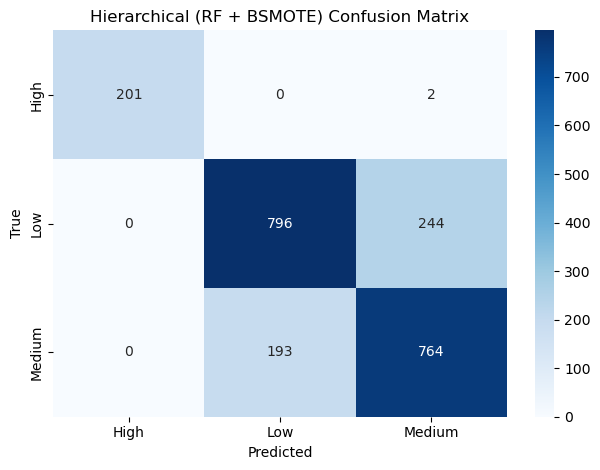

In [27]:
# combo_hier_pipeline.py
import os, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.base import clone

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------- SETTINGS ----------------
RANDOM_STATE = 42
BIN_BOUNDS   = [0, 3, 7, 10]
BIN_LABELS   = ['Low', 'Medium', 'High']

# ---------- 0. LOAD & (optionally) FEATURE ENGINEER ----------
df = pd.read_csv('anxiety.csv')
# (Assume you already added engineered features above this script.)

# ---------- 1. BIN TARGET ----------
df['anxiety_bin'] = pd.cut(
    df['Anxiety Level (1-10)'],
    bins=BIN_BOUNDS, labels=BIN_LABELS,
    include_lowest=True, right=True
)

le = LabelEncoder()
y = le.fit_transform(df['anxiety_bin'])
X = pd.get_dummies(df.drop(['Anxiety Level (1-10)', 'anxiety_bin'], axis=1), drop_first=True).apply(pd.to_numeric)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Handy ids
hi_id = np.where(le.classes_ == 'High')[0][0]
lo_id = np.where(le.classes_ == 'Low')[0][0]
me_id = np.where(le.classes_ == 'Medium')[0][0]

# ---------- 2. DEFINE VARIANTS (GLOBAL CV) ----------
lr_base = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs',
                              max_iter=2000, random_state=42))
])
lr_bal  = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs',
                              class_weight='balanced', max_iter=2000, random_state=42))
])
rf_base = RandomForestClassifier(n_estimators=200, random_state=42)
rf_bal  = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

variants = {
    'LR (base)': lr_base,
    'RF (base)': rf_base,
    'XGB (base)': xgb_base,
    'LR (balanced)': lr_bal,
    'RF (balanced)': rf_bal,
    'LR + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                  max_iter=2000, random_state=42))
    ]),
    'RF + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
    'XGB + SMOTE': ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
    ]),
    'LR + BSMOTE': ImbPipeline([
        ('bsmote', BorderlineSMOTE(random_state=42)),
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs',
                                  max_iter=2000, random_state=42))
    ]),
    'RF + BSMOTE': ImbPipeline([
        ('bsmote', BorderlineSMOTE(random_state=42)),
        ('rf', RandomForestClassifier(n_estimators=200, random_state=42))
    ]),
    'XGB + BSMOTE': ImbPipeline([
        ('bsmote', BorderlineSMOTE(random_state=42)),
        ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
    ])
}

print("CV macro‑F1 for global variants")
print("-"*40)
cv_results = {}
for name, model in variants.items():
    scores = cross_val_score(model, X_train, y_train, cv=5,
                             scoring='f1_macro', n_jobs=-1)
    cv_results[name] = (scores.mean(), scores.std())
    print(f"{name:<20} {scores.mean():.3f} ± {scores.std():.3f}")

best_variant = max(cv_results, key=lambda k: cv_results[k][0])
print(f"\nBest global variant: {best_variant}\n")

best_global = variants[best_variant].fit(X_train, y_train)

# ---------- 3. EVALUATE BEST GLOBAL MODEL ----------
y_pred = best_global.predict(X_test)
print(f"Global Test macro‑F1: {f1_score(y_test, y_pred, average='macro'):.3f}")
print(classification_report(le.inverse_transform(y_test),
                            le.inverse_transform(y_pred), digits=3))

# ---------- 4. HIERARCHICAL USING THAT BEST MODEL ----------
# We clone the best global model for each stage (or swap stage2 to another if you prefer).
from sklearn.base import clone

# Stage 1: High vs Rest
y_hi = (y_train == hi_id).astype(int)
clf_hi = clone(best_global)
clf_hi.fit(X_train, y_hi)

# Stage 2: Low vs Medium (on not-high)
mask_lm = (y_train != hi_id)
y_lm = (y_train[mask_lm] == lo_id).astype(int)
clf_lm = clone(best_global)
clf_lm.fit(X_train[mask_lm], y_lm)

# Predict hierarchically
p_hi = clf_hi.predict(X_test)
pred_final = np.full(len(X_test), me_id)      # default Medium
pred_final[p_hi == 1] = hi_id                 # High where predicted
idx_rest = np.where(p_hi == 0)[0]
pred_final[idx_rest] = np.where(clf_lm.predict(X_test.iloc[idx_rest])==1, lo_id, me_id)

# ---------- 5. EVALUATE HIERARCHICAL ----------
macro_all = f1_score(y_test, pred_final, average='macro')
lm_mask = np.isin(y_test, [lo_id, me_id])
macro_lm  = f1_score(y_test[lm_mask], pred_final[lm_mask], average='macro')

print(f"\nHierarchical (using {best_variant}) -> Macro‑F1(all): {macro_all:.3f} | Macro‑F1(L+M): {macro_lm:.3f}")

y_test_str = le.inverse_transform(y_test)
y_pred_str = le.inverse_transform(pred_final)
print("\nClassification report (hierarchical):\n",
      classification_report(y_test_str, y_pred_str, digits=3))

cm = confusion_matrix(y_test, pred_final, labels=[hi_id, lo_id, me_id])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['High','Low','Medium'],
            yticklabels=['High','Low','Medium'])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title(f"Hierarchical ({best_variant}) Confusion Matrix")
plt.tight_layout()
os.makedirs('plots', exist_ok=True)
plt.savefig('plots/confusion_matrix_hier_best.png')
plt.show()
